In [1]:
%matplotlib inline


# Translation with a Sequence to Sequence Network and Attention

In this tutorial we learn a model to translate from Italian to English.


A sequence to sequence network is composed of two recurrent neural networks: one which encodes the input data to one single vector - the *context* vector - and the other one which decodes the *context* vector to a new sequence.

It has been introduced an [attention
mechanism](https://arxiv.org/abs/1409.0473), which permits the decoder learn to focus over the informative input data in the input sequence.


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading data files

The data for this project is a set of pairs of text of Italian to English translation strings.


There is translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads where we can find the dataset used here.

Let's choose from `English` to `Italian`.
We have to remove the numbers and keep only the strings.


``4555 Devo andare a dormire.	1277	I have to go to sleep.``



We will be representing each word in a language as a one-hot vector.   
The number of words in a language are much more than the number of characters.   
Here, we are going to use only some thousands of words per language.



Here, a class is created to make the mapping between the words and the indexes, and the opposite. Moreover there is a variable counting the words.



In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and remove most punctuation.




In [4]:
# turn UNICODE string to ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, and remove the punctuations and non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

To read the data file we will split the file into lines, and then split lines into pairs.

The files are from English to another language,if we want to translate from Other Language to English I added the ``reverse`` flag to reverse the pairs.




In [5]:
import pandas as pd

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    lines = pd.read_excel(f'{lang1}_to_{lang2}.xlsx',names =['no', 'it', 'n1', 'en'] )
    transl = {
        'it': lines[lang1],
        'en': lines[lang2]
    }
    pairs = []
    for i in range(len(transl['it'])):
      norm_it = normalizeString(transl['it'][i])
      norm_en = normalizeString(transl['en'][i])
      pairs.append([norm_it, norm_en])
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

There are many sentences, but we want to train quite quickly the model, thus, we use only the shorter sentences.  
We decided for a maximum length of 20 words (including the punctuation)




In [6]:
MAX_LENGTH =20

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('it', 'en', False)
print(input_lang.n_words)
print(random.choice(pairs))

Reading lines...
Read 2000 sentence pairs
Trimmed to 1994 sentence pairs
Counting words...
Counted words:
it 2334
en 1937
2334
['non mi sento bene', 'i m not feeling well']


# Question 1
After understanding the Seq2Seq model, modify the code to use the GPU.

## The Seq2Seq Model
### The Encoder

The *encoder* of a *seq2seq* network is a RNN that outputs *some value for every word from the input sentence*. For every input word the encoder
outputs:
1. a vector   
2. a hidden state   
and uses the hidden state for the next input word.

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, bidirectional = True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):

        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)

        _,b_size,h_size = hidden.shape

        if _ == 2: # bidirectional
          hidden = hidden.permute((1,2,0))
          hidden = hidden.reshape((1,b_size,h_size*_))
        return output, hidden

### The Decoder

The decoder is another RNN that takes the encoder output vector and outputs a sequence of words to create the translation.




#### Simple Decoder

In the simplest case of the seq2seq decoder we use only the last output of the encoder.
It is commonly named *context vector* as it encodes
context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the so-called context vector.

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        # at the beginning the decoder input is initialised with the SOS token
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)

            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # teacher forcing - if we have the target, it is treated as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # No teacher forcing - use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1).to(device)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

#### Attention Decoder

If only the context vector is passed between the encoder and decoder, it carries a lot of information of the input sentence.

Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs.

The first introduced attention was the *Bahdanau attention*, which is also known ad *additive attention*, is a commonly used
attention mechanism in sequence-to-sequence models, particularly in neural machine translation tasks. It was introduced by Bahdanau et al. in their
paper titled [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf)_.

This attention mechanism employs a learned alignment model to compute attention
scores between the encoder and decoder hidden states. It utilises a feed-forward
neural network to calculate alignment scores.



## Question 2

Implement the Badhanau attention and the Decoder class which is using the attention.

In [11]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1).to(device)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1).to(device)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2).to(device)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('it', 'en', False)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)

        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

## Training

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




### Training the Model

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained
network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf)_.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [13]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [14]:
import time, math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [15]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [17]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, __ = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, __

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [18]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('INPUT:', pair[0])
        print('TG:', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('PRED:', output_sentence)
        print('')

## Training and Evaluating




### Using DecoderRNN

Reading lines...
Read 2000 sentence pairs
Trimmed to 1994 sentence pairs
Counting words...
Counted words:
it 2334
en 1937
0m 14s (- 0m 58s) (5 20%) 1.5503
0m 26s (- 0m 39s) (10 40%) 0.6819
0m 38s (- 0m 25s) (15 60%) 0.2573
0m 50s (- 0m 12s) (20 80%) 0.1000
1m 1s (- 0m 0s) (25 100%) 0.0522


<Figure size 640x480 with 0 Axes>

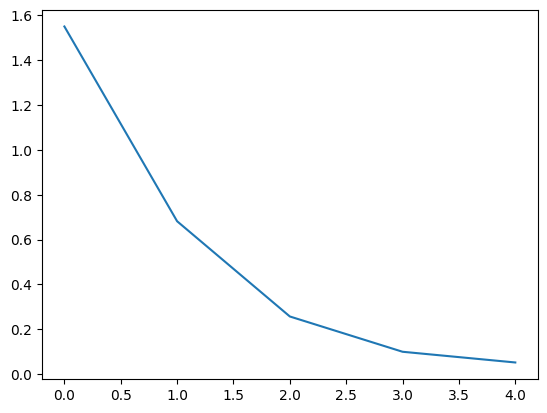

In [19]:
n_epochs_rnn = 25
hidden_size_rnn = 128
batch_size_rnn = 16

input_lang, output_lang, train_dataloader = get_dataloader(batch_size_rnn)

encoder_rnn = EncoderRNN(input_lang.n_words, hidden_size_rnn).to(device)
decoder_rnn = DecoderRNN(hidden_size_rnn*2, output_lang.n_words).to(device)

train(train_dataloader, encoder_rnn, decoder_rnn, n_epochs_rnn, print_every=5, plot_every=5)

Set dropout layers to ``eval`` mode



In [37]:
encoder_rnn.eval()
decoder_rnn.eval()
evaluateRandomly(encoder_rnn, decoder_rnn)

INPUT: abbiamo molti compiti da fare
TG: we have a lot of homework to do
PRED: we have a lot of homework to do <EOS>

INPUT: qualcuno sta suonando il pianoforte
TG: someone is playing the piano
PRED: someone is playing <EOS>

INPUT: e accusato di rapimento
TG: he s being accused of kidnapping
PRED: he is accused of kidnapping <EOS>

INPUT: ci sei mai stato ?
TG: have you ever been there ?
PRED: have you ever been ? <EOS>

INPUT: sta zitto e ascolta !
TG: shut up and listen !
PRED: shut up and listen <EOS>

INPUT: e scoppiato un incendio nel mio vicinato la scorsa notte
TG: a fire broke out in my neighborhood last night
PRED: a fire broke out in my neighborhood <EOS>

INPUT: ti senti male ?
TG: are you feeling sick ?
PRED: are you feeling sick ? <EOS>

INPUT: era in tempo per l appuntamento
TG: he was in time for the appointment
PRED: he was in the appointment <EOS>

INPUT: se avessi piu soldi potrei traslocare in una casa piu grande
TG: if i had more money i could move to a bigger hous

### Using AttnDecoderRNN

Reading lines...
Read 2000 sentence pairs
Trimmed to 1994 sentence pairs
Counting words...
Counted words:
it 2334
en 1937
0m 23s (- 5m 52s) (5 6%) 1.4660
0m 47s (- 5m 34s) (10 12%) 0.5490
1m 10s (- 5m 6s) (15 18%) 0.1621
1m 33s (- 4m 41s) (20 25%) 0.0587
1m 57s (- 4m 18s) (25 31%) 0.0367
2m 20s (- 3m 54s) (30 37%) 0.0301
2m 44s (- 3m 31s) (35 43%) 0.0252
3m 7s (- 3m 7s) (40 50%) 0.0230
3m 30s (- 2m 44s) (45 56%) 0.0258
3m 53s (- 2m 20s) (50 62%) 0.0215
4m 16s (- 1m 56s) (55 68%) 0.0201
4m 40s (- 1m 33s) (60 75%) 0.0215
5m 4s (- 1m 10s) (65 81%) 0.0232
5m 28s (- 0m 46s) (70 87%) 0.0187
5m 52s (- 0m 23s) (75 93%) 0.0178
6m 16s (- 0m 0s) (80 100%) 0.0185


<Figure size 640x480 with 0 Axes>

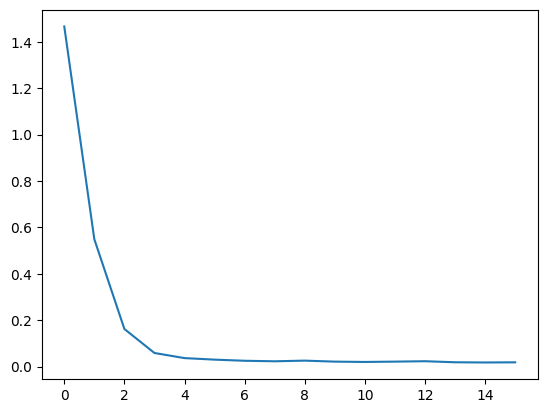

In [38]:
n_epochs_att = 80
hidden_size_att = 128
batch_size_att = 16

input_lang, output_lang, train_dataloader = get_dataloader(batch_size_att)

encoder_rnn_2 = EncoderRNN(input_lang.n_words, hidden_size_att).to(device)
decoder_attdec_rnn = AttnDecoderRNN(hidden_size_att*2, output_lang.n_words).to(device)

train(train_dataloader, encoder_rnn_2, decoder_attdec_rnn, n_epochs_att, print_every=5, plot_every=5)

In [22]:
encoder_rnn_2.eval()
decoder_attdec_rnn.eval()
evaluateRandomly(encoder_rnn_2, decoder_attdec_rnn)

INPUT: quello non succedera
TG: that won t happen
PRED: that won t happen to him anymore <EOS>

INPUT: sono uno studente universitario
TG: i m a university student
PRED: i am a university student student my camera car last night student student sun student romantic sun student power power

INPUT: la liberta non e gratuita
TG: freedom is not free
PRED: freedom is not easy to carry out <EOS>

INPUT: suona il piano
TG: she plays the piano
PRED: she plays the best job in the dictionary under his arm <EOS>

INPUT: il treno non e ancora arrivato
TG: the train has not arrived yet
PRED: the train has not arrived yet <EOS>

INPUT: i pesci sono animali a sangue freddo
TG: fish are cold blooded animals
PRED: fish are cold blooded animals random likes trace trace trace trace trace trace trace trace trace trace trace trace trace

INPUT: hai una macchina fotografica ?
TG: do you have a camera ?
PRED: do you have a camera ? <EOS>

INPUT: muoio di fame !
TG: i m starving !
PRED: i m starving ! <EOS>



### Visualizing Attention

To visualise the attention is useful as you can understand what are the informative parts of the input data which are taken into account to perform the decoding.




## Question 3
Use the function `evaluateAndShowAttention()` to see the attention weights for the translation for a single sentence.

In [23]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence, encoder, decoder):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


input = non ti preoccupare
output = don t worry <EOS>


<ipython-input-23-296dee74a5cc>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-23-296dee74a5cc>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


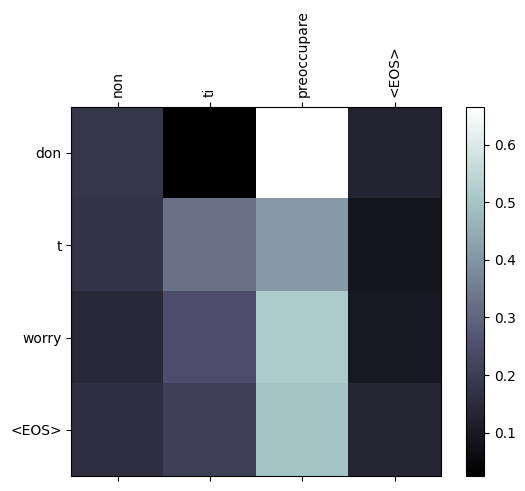

In [24]:
evaluateAndShowAttention("non ti preoccupare", encoder_rnn_2, decoder_attdec_rnn)

input = mio fratello vive a tokyo
output = my brother lives in tokyo <EOS>


<ipython-input-23-296dee74a5cc>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-23-296dee74a5cc>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


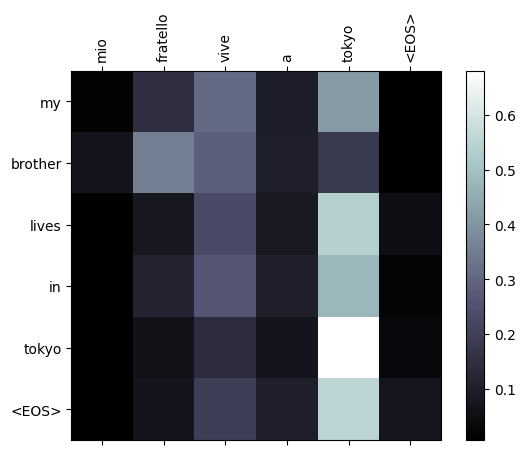

In [25]:
evaluateAndShowAttention("mio fratello vive a tokyo", encoder_rnn_2, decoder_attdec_rnn)

input = domani e il mio compleanno
output = tomorrow is my birthday birthday <EOS>


<ipython-input-23-296dee74a5cc>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-23-296dee74a5cc>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


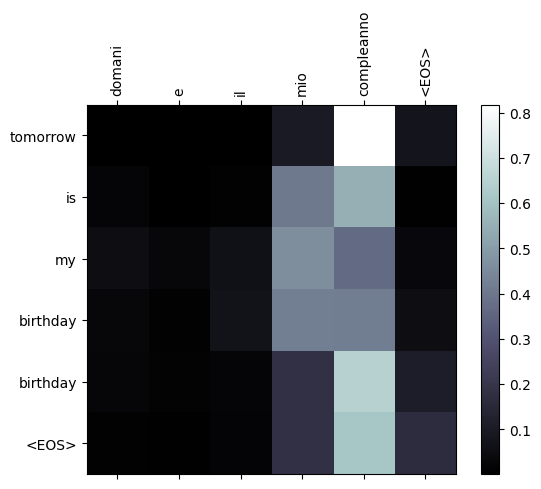

In [30]:
evaluateAndShowAttention("domani e il mio compleanno", encoder_rnn_2, decoder_attdec_rnn)

input = tutti conoscono il suo nome
output = everyone knows his name <EOS>


<ipython-input-23-296dee74a5cc>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-23-296dee74a5cc>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


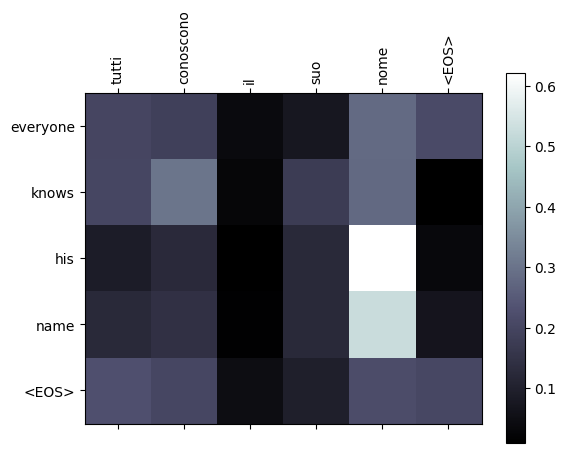

In [27]:
evaluateAndShowAttention("tutti conoscono il suo nome", encoder_rnn_2, decoder_attdec_rnn)

input = e un errore comune
output = it s a common mistake <EOS>


<ipython-input-23-296dee74a5cc>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-23-296dee74a5cc>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


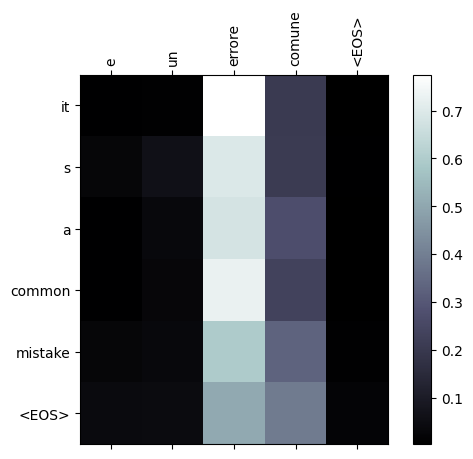

In [39]:
evaluateAndShowAttention("e un errore comune", encoder_rnn_2, decoder_attdec_rnn)